In [1]:
from cdsgd import DSClustering
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from lime.lime_tabular import LimeTabularExplainer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score, accuracy_score
import wittgenstein as lw
#pca
from sklearn.decomposition import PCA

In [2]:
Gas = pd.read_csv('../data/gas_drift.csv')
#drop class and id
Gas = Gas.drop(columns=['Class'])
print("Shape of Gas data: ", Gas.shape)
#tipos de las columnas


Shape of Gas data:  (13910, 128)


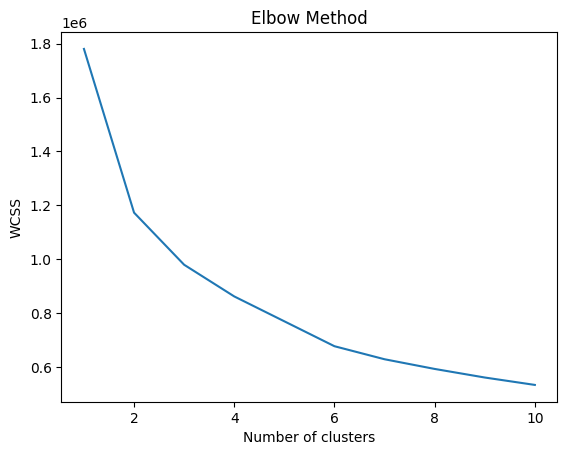

In [5]:
#elbow method
scaler = StandardScaler()
Gas_scaled = scaler.fit_transform(Gas)
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(Gas_scaled)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()


Kmeans Silhouette Score: 0.4000427617608482 Number of Clusters: 3
Agglomerative Silhouette Score: 0.4250908326705769 Number of Clusters: 3


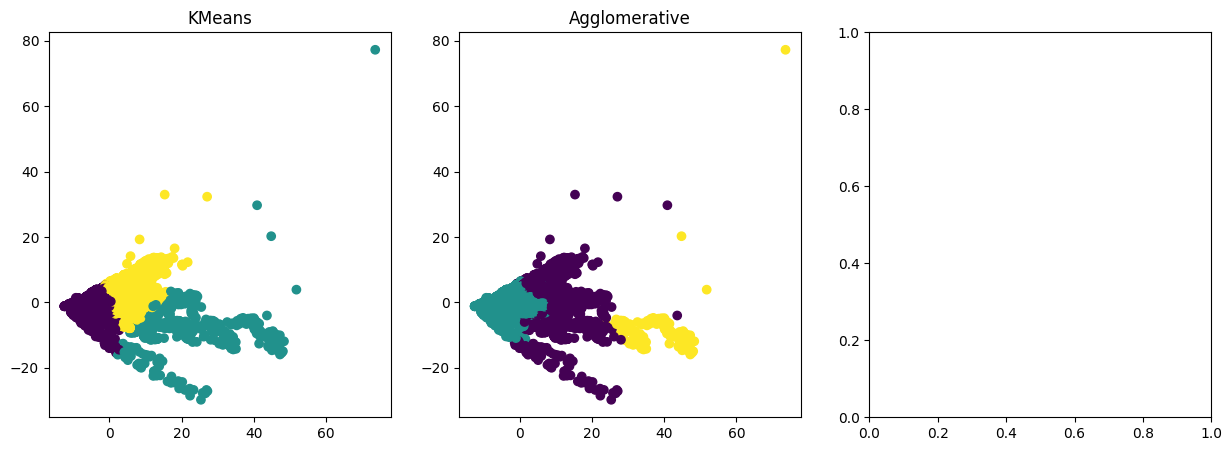

In [6]:
scaler = StandardScaler()
Gas_scaled = scaler.fit_transform(Gas)
Gas = pd.DataFrame(Gas_scaled, columns=Gas.columns)
nClusters = 3
models = []
kmeans = KMeans(n_clusters=nClusters)
kmeans_labels = kmeans.fit_predict(Gas)
models.append({'model': kmeans, 'name': 'KMeans', 'labels': kmeans_labels})
print('Kmeans Silhouette Score:', silhouette_score(Gas, kmeans_labels), "Number of Clusters:", len(np.unique(kmeans_labels)))

agg = AgglomerativeClustering(n_clusters=nClusters)
agg_labels = agg.fit_predict(Gas)
models.append({'model': agg, 'name': 'Agglomerative', 'labels': agg_labels})
print('Agglomerative Silhouette Score:', silhouette_score(Gas, agg_labels), "Number of Clusters:", len(np.unique(agg_labels)))

# visualize the clusters
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, model in enumerate(models):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(Gas)
    ax[i].scatter(pca_result[:, 0], pca_result[:, 1], c=model['labels'], cmap='viridis')
    ax[i].set_title(model['name'])
plt.show()

## Lime

In [7]:
clustterToExplain = 1
i = 100 # instance to explain

#KMeans
y = (kmeans_labels == clustterToExplain).astype(int)
X_train, X_test, y_train, y_test = train_test_split(Gas, y, test_size=0.2, random_state=42)
clf = LogisticRegression()
clf.fit(Gas, y)
print('KMeans Accuracy:', accuracy_score(y, clf.predict(Gas)))
explainer = LimeTabularExplainer(Gas.values, mode='classification', feature_names=Gas.columns, class_names=['0', '1'], discretize_continuous=True)
exp = explainer.explain_instance(Gas.values[i], clf.predict_proba, num_features=5)
exp.show_in_notebook(show_table=True, show_all=False)

#Agglomerative
y = (agg_labels == clustterToExplain).astype(int)
X_train, X_test, y_train, y_test = train_test_split(Gas, y, test_size=0.2, random_state=42)
clf = LogisticRegression()
clf.fit(Gas, y)
print('Agglomerative Accuracy:', accuracy_score(y, clf.predict(Gas)))
explainer = LimeTabularExplainer(Gas.values, mode='classification', feature_names=Gas.columns, class_names=['0', '1'], discretize_continuous=True)
exp = explainer.explain_instance(Gas.values[i], clf.predict_proba, num_features=5)
exp.show_in_notebook(show_table=True, show_all=False)

KMeans Accuracy: 0.9989935298346513


c:\Users\Daniel\Documents\GitHub\trabajo-dirigido\env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Agglomerative Accuracy: 0.9942487419122933


c:\Users\Daniel\Documents\GitHub\trabajo-dirigido\env\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


## Decision tree

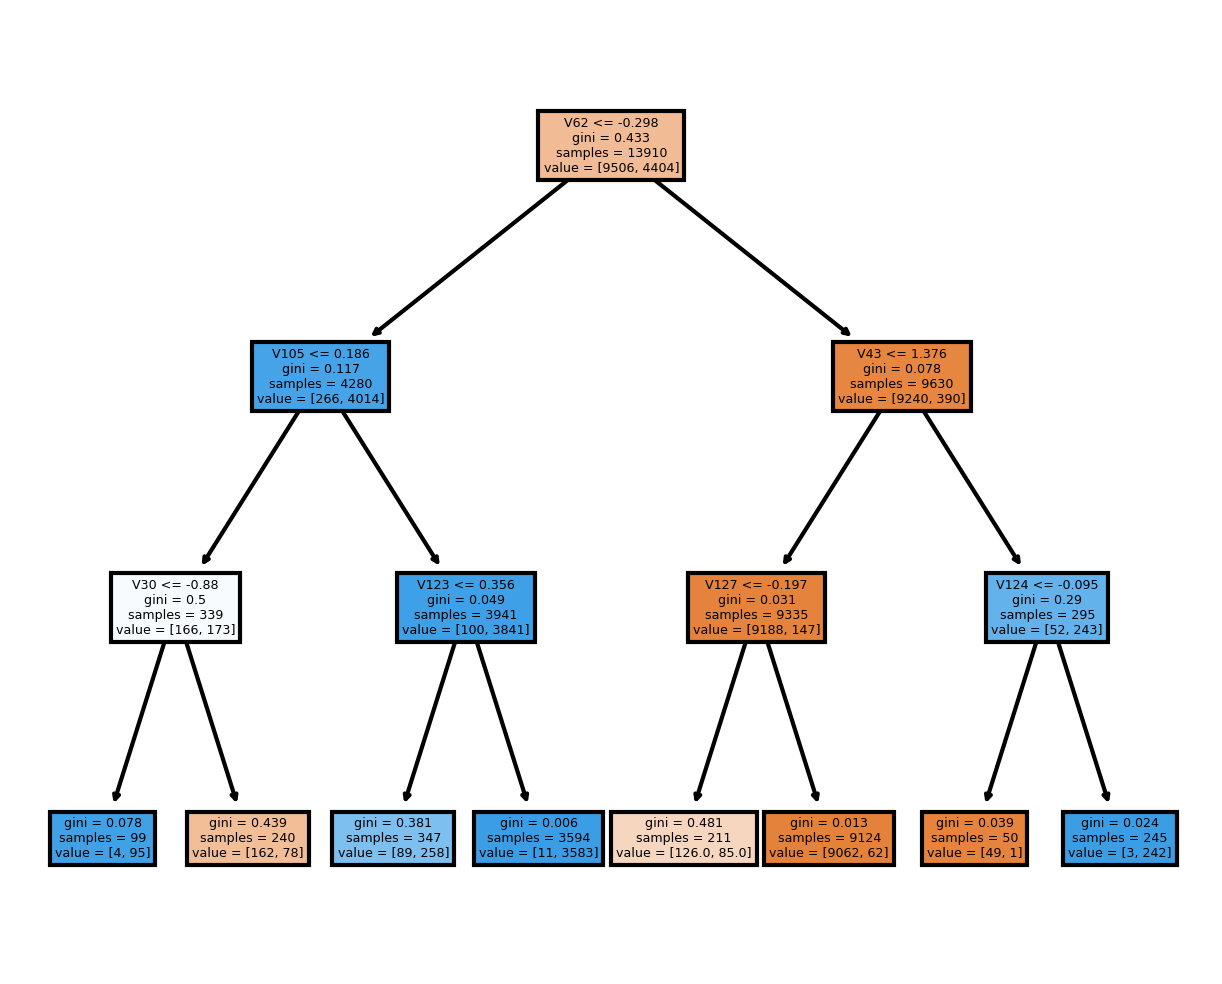

Decision Tree Accuracy: 0.9760603882099209


In [8]:
# interpretamos con decision tree
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(Gas, kmeans_labels)
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (5,4), dpi = 300)
plot_tree(dt, filled=True, ax=axes, feature_names=Gas.columns)
plt.show()
y_pred = dt.predict(Gas)
print('Decision Tree Accuracy:', accuracy_score(kmeans_labels, y_pred))


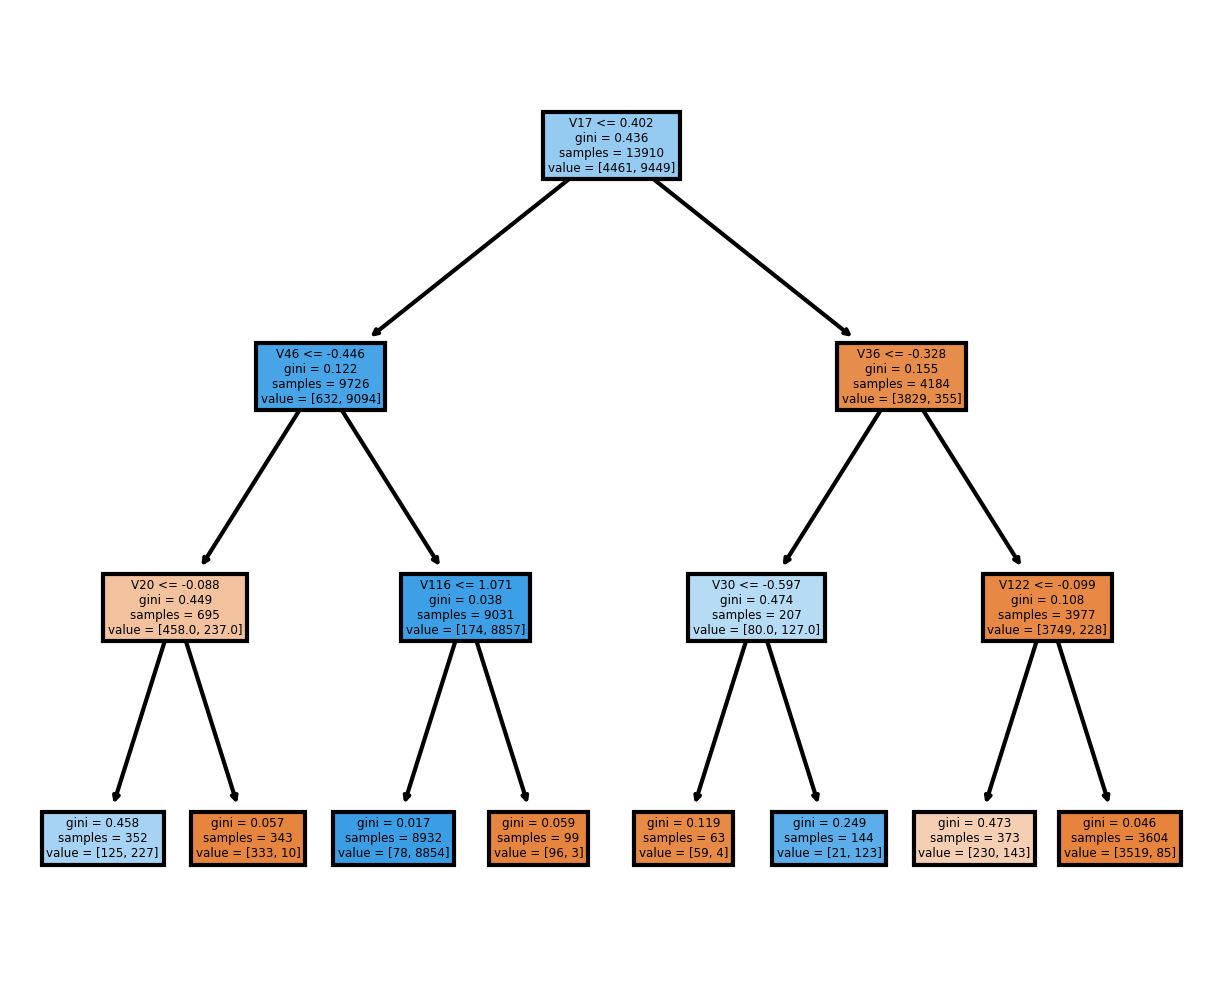

Decision Tree Accuracy: 0.9662832494608196


In [9]:
# interpretamos con decision tree
dt = DecisionTreeClassifier(max_depth=3)
dt.fit(Gas, agg_labels)
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (5,4), dpi = 300)
plot_tree(dt, filled=True, ax=axes, feature_names=Gas.columns)
plt.show()
y_pred = dt.predict(Gas)
print('Decision Tree Accuracy:', accuracy_score(agg_labels, y_pred))

# RIPPER

In [10]:
pos = 0
# cambiamos las etiquetas para que el positivo sea el cluster 0
kmeans_labels_pos = (kmeans_labels == pos).astype(int)
agg_labels_pos = (agg_labels == pos).astype(int)
# KMeans
ripper = lw.RIPPER()
df = pd.concat([Gas, pd.DataFrame(kmeans_labels_pos, columns=['label'])], axis=1)
ripper.fit(df, class_feat='label', pos_class=1)
print(ripper.ruleset_)
y_pred = ripper.predict(Gas)
print('RIPPER Accuracy KMeans:', accuracy_score(kmeans_labels_pos, y_pred))
# Agglomerative
ripper = lw.RIPPER()
df = pd.concat([Gas, pd.DataFrame(agg_labels_pos, columns=['label'])], axis=1)
ripper.fit(df, class_feat='label', pos_class=1)
print(ripper.ruleset_)
y_pred = ripper.predict(Gas)
print('RIPPER Accuracy Agglomerative:', accuracy_score(agg_labels_pos, y_pred))

[[V21=-0.21--0.17^V27=-0.96--0.81] V [V32=0.2-0.25^V56=0.57-0.69] V [V111=0.19-0.42] V [V56=>0.69^V21=<-0.24] V [V111=0.42-0.6] V [V111=-0.045-0.19^V54=-0.005-0.2] V [V111=0.6-0.8] V [V111=0.8-0.99] V [V111=-0.045-0.19^V27=-0.19-0.072] V [V30=-0.053-0.23^V97=0.12-0.39] V [V111=>0.99^V41=<-1.02] V [V17=0.066-0.4^V110=-0.38--0.12^V28=-0.21--0.064] V [V110=-0.12-0.19^V97=-0.38--0.14^V99=-0.44--0.18] V [V99=-0.18-0.11^V59=-0.49--0.22^V51=-0.49--0.23] V [V105=-0.13-0.16^V55=-0.32-0.029^V89=0.023-0.33] V [V87=0.26-0.48^V83=-0.29-0.082] V [V83=-0.53--0.29^V31=0.18-0.31] V [V111=-0.045-0.19^V102=0.17-0.44] V [V51=0.12-0.39^V77=-0.21-0.0019^V46=-0.21-0.076] V [V102=-0.068-0.17^V62=0.46-0.64] V [V123=-0.25-0.085^V116=-0.31--0.054^V61=-0.33--0.089^V22=-0.33--0.025] V [V49=-1.09--0.85] V [V105=-0.13-0.16^V30=-0.71--0.34^V59=0.1-0.39] V [V37=<-0.44^V10=<-0.3^V101=<-0.83] V [V102=-0.35--0.068^V22=-0.33--0.025^V28=-0.064-0.16] V [V102=-0.068-0.17^V113=0.0058-0.33^V84=0.6-1.34] V [V91=-0.5--0.26^V31=-

## DSClustering

In [9]:
cdsgd = DSClustering(data=Gas, most_voted=True)
cdsgd.generate_categorical_rules()
cdsgd_labels = cdsgd.predict()
models.append({'model': cdsgd, 'name': 'CD-SGD con 2 clusters', 'labels': cdsgd_labels})
if len(np.unique(cdsgd_labels)) > 1:
    print('CD-SGD Silhouette Score:', silhouette_score(Gas, cdsgd_labels), "Number of Clusters:", len(np.unique(cdsgd_labels)))
#vvisualize the clusters
pca = PCA(n_components=2)
pca_result = pca.fit_transform(Gas)
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=cdsgd_labels, cmap='viridis')
plt.title('CD-SGD')
plt.legend()
plt.show()

c:\Users\Daniel\Documents\GitHub\trabajo-dirigido\env\Lib\site-packages\cdsgd\ClusteringSelector.py:248: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  row_modes[0][x] = self.get_best_labels()[x]


Optimization started
Processing epoch	1	1.0000	

In [ ]:
cdsgd.print_most_important_rules()

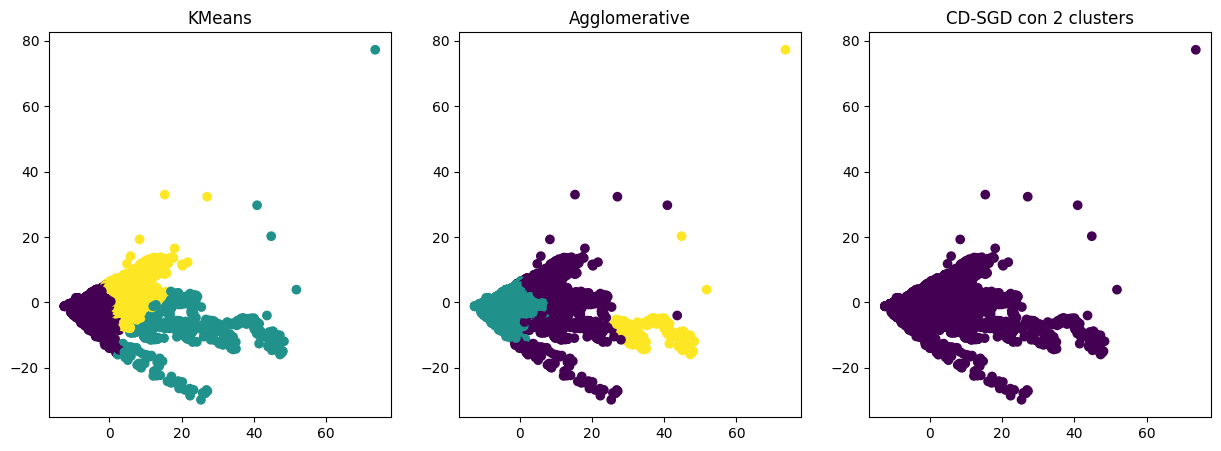

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for i, model in enumerate(models):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(Gas)
    ax[i].scatter(pca_result[:, 0], pca_result[:, 1], c=model['labels'], cmap='viridis')
    ax[i].set_title(model['name'])
plt.show()